In [1]:
!make docker-image > /dev/null 2>&1

In [2]:
!CONTAINER_CMD="bash -lc 'make install-ycsb'" make docker > /dev/null 2>&1

In [1]:
from python.kernmlops.analysis.collector import Collector

There are two ways to run kermit:
- With the raw config
- With a pre-programmed benchmark config

In [2]:
import subprocess
import sys
collect = Collector("./config/raw_overrides.yaml")
# This creates a raw collector, I suggest looking into this file to learn more

w = open("hello.txt", "bw")
collect.start_collection(logfile=w)
print("Collection has started")
# Start collection

f = open("blah.txt", "w")
bench_test = subprocess.Popen(["cat", "defaults.yaml"], stdout=f)
bench_test.wait()
# Run benchmark application

print("Exit application")
raw_coll_info = collect.stop_collection()
print(raw_coll_info)
# Stop the Collector

Collection has started
Exit application
./config/raw_overrides.yaml results in {'quanta_runtime': [PosixPath('data/curated/faux/8f3fa8cf-9cb0-4f7c-928d-dedc7c7ac658/quanta_runtime.end.parquet')], 'process_trace': [PosixPath('data/curated/faux/8f3fa8cf-9cb0-4f7c-928d-dedc7c7ac658/process_trace.end.parquet')], 'file_data': [PosixPath('data/curated/faux/8f3fa8cf-9cb0-4f7c-928d-dedc7c7ac658/file_data.end.parquet')], 'dtlb_walk_duration': [PosixPath('data/curated/faux/8f3fa8cf-9cb0-4f7c-928d-dedc7c7ac658/dtlb_walk_duration.end.parquet')], 'quanta_queued_time': [PosixPath('data/curated/faux/8f3fa8cf-9cb0-4f7c-928d-dedc7c7ac658/quanta_queued_time.end.parquet')], 'process_metadata': [PosixPath('data/curated/faux/8f3fa8cf-9cb0-4f7c-928d-dedc7c7ac658/process_metadata.end.parquet')], 'memory_usage': [PosixPath('data/curated/faux/8f3fa8cf-9cb0-4f7c-928d-dedc7c7ac658/memory_usage.end.parquet')], 'block_io': [PosixPath('data/curated/faux/8f3fa8cf-9cb0-4f7c-928d-dedc7c7ac658/block_io.end.parquet')], 

In [3]:
collect = Collector("./config/start_overrides.yaml")
# This is a simple redis benchmark config

w = open("hello.txt", "bw")
collect.start_collection(logfile=w)
# Start collection

start_coll_info = collect.wait()
#Wait for collector to finish

./config/start_overrides.yaml results in {'quanta_runtime': [PosixPath('data/curated/redis/ad589112-5785-4006-a1f0-1706bb94dce0/quanta_runtime.end.parquet')], 'process_trace': [PosixPath('data/curated/redis/ad589112-5785-4006-a1f0-1706bb94dce0/process_trace.end.parquet')], 'file_data': [PosixPath('data/curated/redis/ad589112-5785-4006-a1f0-1706bb94dce0/file_data.end.parquet')], 'dtlb_walk_duration': [PosixPath('data/curated/redis/ad589112-5785-4006-a1f0-1706bb94dce0/dtlb_walk_duration.end.parquet')], 'quanta_queued_time': [PosixPath('data/curated/redis/ad589112-5785-4006-a1f0-1706bb94dce0/quanta_queued_time.end.parquet')], 'process_metadata': [PosixPath('data/curated/redis/ad589112-5785-4006-a1f0-1706bb94dce0/process_metadata.end.parquet')], 'memory_usage': [PosixPath('data/curated/redis/ad589112-5785-4006-a1f0-1706bb94dce0/memory_usage.end.parquet')], 'block_io': [PosixPath('data/curated/redis/ad589112-5785-4006-a1f0-1706bb94dce0/block_io.end.parquet')], 'itlb_misses': [PosixPath('dat

In [5]:
from python.kernmlops.analysis.bloat import filter_process_trace, export_graph_data_frame, create_graph

In [ ]:
w = open("hello.txt", "bw")
collect = Collector("./config/redis_never.yaml")
collect.start_collection(logfile=w)
redis_never_info = collect.wait()
print("Never Finished")
collect = Collector("./config/redis_madvise.yaml")
collect.start_collection(logfile=w)
redis_madvise_info = collect.wait()
print("Madvise Finished")
collect = Collector("./config/redis_always.yaml")
collect.start_collection(logfile=w)
redis_always_info = collect.wait()
print("Always Finished")

In [ ]:
proc_name = "redis-server"
from IPython.display import Image, display
plt = create_graph([("4k", redis_never_info),
                    ("thp", redis_always_info)],
                   proc_name, 0, 
                   "redis-server", 0,
                   "Redis driven by YCSB with Insertions and Deletes using Jemalloc")
plt.save(f"deletes-{proc_name}.png")
Image(filename=f"./deletes-{proc_name}.png")

In [ ]:
from plotnine import geom_bar, scale_fill_manual
import pandas as pd
width = filter_process_trace(pl.read_parquet(
        redis_never_info["process_trace"], allow_missing_columns=True
    )).filter(pl.col("full_name") == "java").width
df = pl.DataFrame()
for i in range(1, width, 2):
    extract_df = export_graph_data_frame([("4k", redis_never_info),
                    ("thp", redis_always_info)],
                   proc_name, 0, 
                   "java", i)
    extract_df = extract_df.sort("norm_ts_ns")
    last_thp = extract_df.filter(pl.col("policy") == "thp").select(pl.col("count").last()).row(0)[0]
    last_4k = extract_df.filter(pl.col("policy") == "4k").select(pl.col("count").last()).row(0)[0]
    tag = "insert" if (((i -1)/ 2) % 2) == 0 else "delete"
    df = pl.concat([df, pl.DataFrame({ "entry": i//4, "bloat" : last_thp - last_4k, "phase" : tag})])
df = df.to_pandas()
df["phase"] = pd.Categorical(df['phase'], categories=["insert", "delete"], ordered=True)
plt = (ggplot(df)
            + aes("entry", y="bloat", fill="phase")
            + geom_bar(stat='identity', position='dodge')
            + labs(x="Invocation of YCSB",
                   y="4kB Pages",
                   title="Bloat for YCSB with Jemalloc (THP - 4k)")
            + scale_fill_manual(values=['#ff7f0e', '#1f77b4'])
           )
plt.save(f"deletes-redis-server-bloat.png")
Image(filename=f"./deletes-redis-server-bloat.png")

In [59]:
extract_df = export_graph_data_frame([
                    ("thp", redis_always_info)],
                   "redis-server", 0, 
                   "redis-server", 0)
extract_df.select(pl.col("count").max()).row(0)[0]

2693277

In [64]:
# Don't forget to deploy nn
collect = Collector("./config/redis_always.yaml")
collect.start_collection(None)
redis_learned_info = collect.wait()
print("Learned Finished")

KeyboardInterrupt: 

In [20]:
from IPython.display import Image, display
plt = create_graph([("4k", redis_never_info),
                    ("madvise", redis_madvise_info),
                    ("thp", redis_always_info),
                    ("learned", redis_learned_info)],
                   "redis-server", 0, 
                   "redis-server", 0,
                   "Redis driven by YCSB with Insertions and Deletes using Jemalloc")
plt.save("learned-tcmalloc-redis.png")
Image(filename="./learned-tcmalloc-redis.png")

shape: (1, 5)
┌────────┬─────────────────┬──────────────┬─────────────────┬───────────────┐
│ pid    ┆ start_ns        ┆ full_name    ┆ end_ns          ┆ duration      │
│ ---    ┆ ---             ┆ ---          ┆ ---             ┆ ---           │
│ i64    ┆ i64             ┆ str          ┆ i64             ┆ i64           │
╞════════╪═════════════════╪══════════════╪═════════════════╪═══════════════╡
│ 353388 ┆ 464556609742862 ┆ redis-server ┆ 466320338242564 ┆ 1763728499702 │
└────────┴─────────────────┴──────────────┴─────────────────┴───────────────┘
shape: (1, 5)
┌────────┬─────────────────┬──────────────┬─────────────────┬───────────────┐
│ pid    ┆ start_ns        ┆ full_name    ┆ end_ns          ┆ duration      │
│ ---    ┆ ---             ┆ ---          ┆ ---             ┆ ---           │
│ i64    ┆ i64             ┆ str          ┆ i64             ┆ i64           │
╞════════╪═════════════════╪══════════════╪═════════════════╪═══════════════╡
│ 353388 ┆ 464556609742862 ┆ redis-s

/home/adityat/.local/share/virtualenvs/KernMLOps-XVq26_cC/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/adityat/.local/share/virtualenvs/KernMLOps-XVq26_cC/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: learned-redis.png


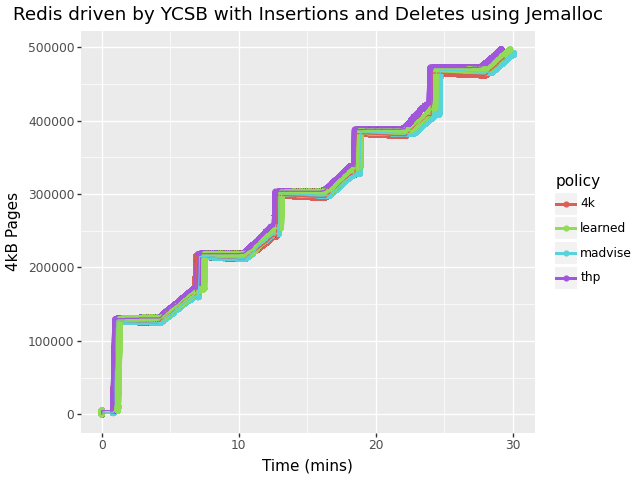

In [21]:
Image(filename="./learned-tcmalloc-redis.png")